# Electricity Customer에 대해서 수행

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_forecasting.metrics import SMAPE,RMSE,MAE
from captum.attr import IntegratedGradients,NoiseTunnel

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def MSE(pred,target):
    return torch.mean((pred-target)**2,dim = 0) # reduction까지 취해줌

## 1. 모델 구성하기
* 시간단위의 데이터로써 24x30 =720 즉 30일을 바라봄

In [3]:
data = pd.read_csv('../../GeneralData/ElectricityCustomer.csv')
sequence_length = 720
pred_len = 360

In [4]:
data = data.drop(columns='Unnamed: 0')

In [5]:
data = data[['customer2']]

In [6]:
data

,customer2
0,96.017070
1,93.172119
2,98.150782
3,87.482219
4,88.904694
...,...
8756,100.995733
8757,91.038407
8758,88.193457
8759,85.348506


<AxesSubplot: >

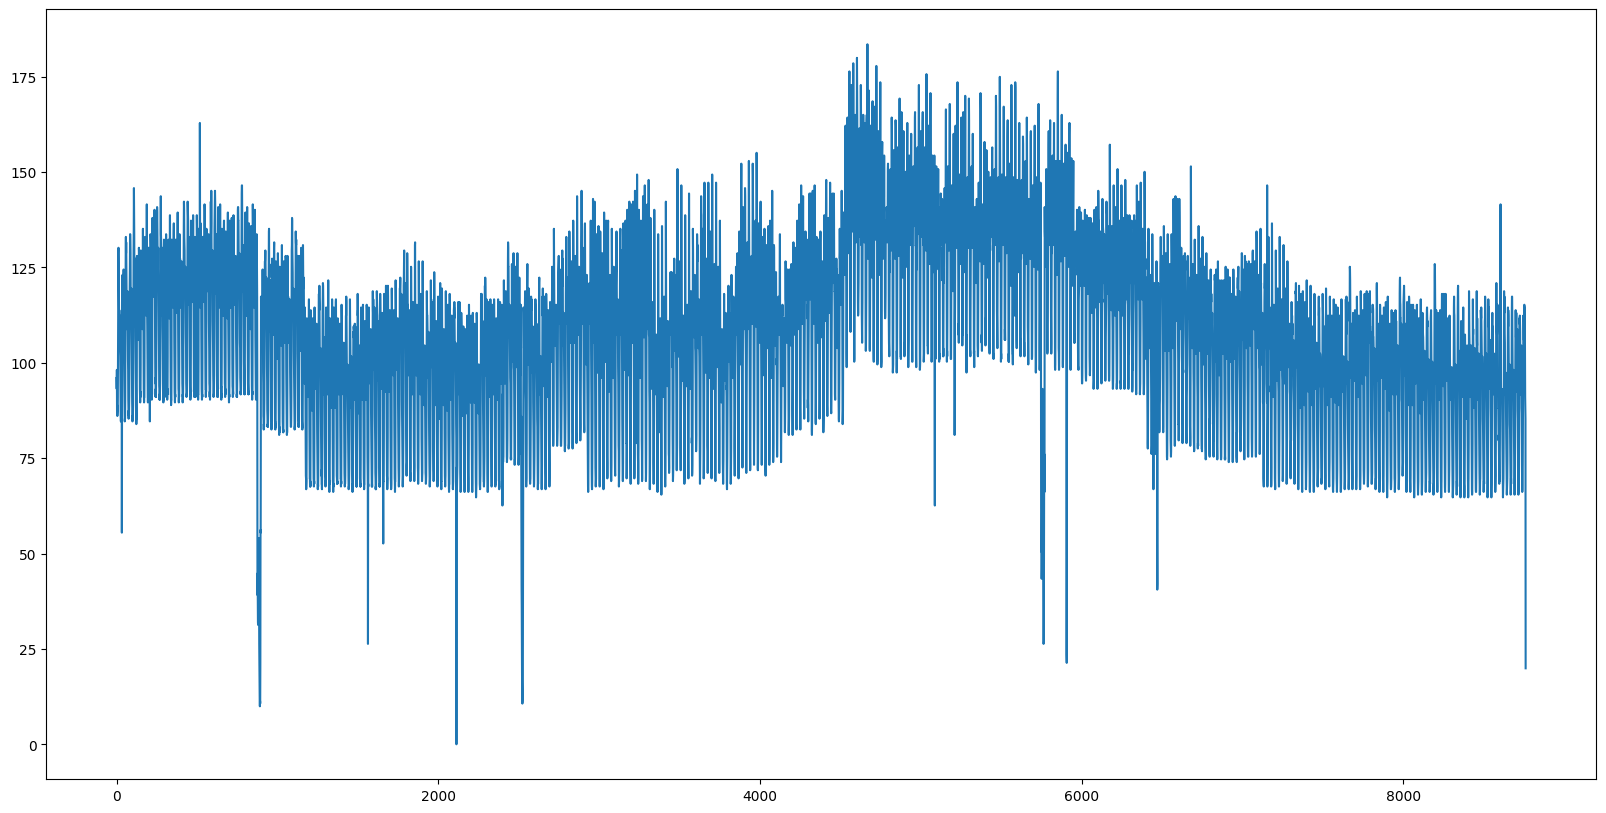

In [7]:
plt.figure(figsize=(20,10))
data['customer2'].plot()

In [8]:
from torch import FloatTensor as FloatTensor

In [9]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(0,len(x)-sequence_length-pred_len+1):
        seq_list.append(x.iloc[i:i+sequence_length].values)
        target_list.append(x.iloc[i+sequence_length:i+sequence_length+pred_len].values)
        
    return FloatTensor(seq_list).view(-1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,pred_len).to(device)

In [10]:
split = 24*7 # 24시간 x 7로써 1주일을 테스트셋으로 만듦

In [11]:
seed = 42

In [12]:
device = torch.device("cuda:0")

In [13]:
class Model(nn.Module):
    def __init__(self,train_index):
        super().__init__()
        self.seq_len = len(train_index)
        self.pred_len = 360
        self.train_index = train_index
        
        self.first_layer = nn.Linear(self.seq_len,self.seq_len//2)
        self.second_layer = nn.Linear(self.seq_len//2,self.seq_len//4)
        self.third_layer = nn.Linear(self.seq_len//4,self.pred_len)
        
        self.first_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.seq_len//2,self.seq_len]))
        self.second_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.seq_len//4,self.seq_len//2]))
        self.third_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len//4]))
    def forward(self,x):
        first_result = self.first_layer(x[:,self.train_index]) 
        second_result = self.second_layer(first_result)
        final_result = self.third_layer(second_result)
        return final_result

# 3. Train-Validation set으로 쪼개기

In [14]:
data

,customer2
0,96.017070
1,93.172119
2,98.150782
3,87.482219
4,88.904694
...,...
8756,100.995733
8757,91.038407
8758,88.193457
8759,85.348506


* 8761개 중 일주일치 데이터인 168개의 데이터를 Test Set
* 8761 중 0.2의 비율인 1752개는 validation set
* 8761개 중 0.8의 비율인 7009개는 train set

In [15]:
val_num = 1752

In [16]:
train = data.iloc[:-split-val_num]
val = data.iloc[-split-val_num:-split]
x_train,y_train = seq_data(train, sequence_length = sequence_length, pred_len = pred_len)
x_val,y_val = seq_data(val, sequence_length = sequence_length, pred_len = pred_len)
train_dataset = TensorDataset(x_train,y_train)
val_dataset = TensorDataset(x_val,y_val)
training = DataLoader(train_dataset,batch_size=64)
validation = DataLoader(val_dataset,batch_size=64)

/tmp/ipykernel_797712/3825588569.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,pred_len).to(device)


In [17]:
train.tail(11)

,customer2
6830,116.642959
6831,105.263158
6832,102.418208
6833,100.284495
6834,105.974395
6835,117.354196
6836,124.466572
6837,110.953058
6838,99.573257
6839,91.749644


In [18]:
y_train.size()

torch.Size([5762, 360])

In [19]:
y_train[-1,-10:]

tensor([105.2632, 102.4182, 100.2845, 105.9744, 117.3542, 124.4666, 110.9531,
         99.5733,  91.7496,  87.4822], device='cuda:0')

In [20]:
next(iter(validation))[0].size()

torch.Size([64, 720])

In [21]:
x_train.size()

torch.Size([5762, 720])

In [22]:
x_val.size()

torch.Size([673, 720])

In [23]:
y_val.size()

torch.Size([673, 360])

### 위와 같은 방식으로 validation-set에 대해서 기여도를 구하면 될 것이다.
-> 모든 batch의 각 sample에 대해서 Ig를 통한 attribution을 구해서 모든 batch에 걸쳐서 더한후 그것을 평균시킨다.<br>
-> 결과적으로 모든 validation set에 대한 attribution을 평균한다.

In [24]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
train_index = np.arange(sequence_length)
model = Model(train_index).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
num_epochs = 100
n= len(training)

### 기본 모델 training

In [25]:
import copy

In [26]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
minimal_loss=np.inf
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
#         print(outputs.size())
        outputs = outputs.view(-1,1)    
        labels = labels.view(-1,1)
        
        # defining loss
        loss = MSE(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model

Epoch [1]/[100] running accumulative loss across all batches: 96192.958
changed
changed
changed
Epoch [21]/[100] running accumulative loss across all batches: 42835.016
Epoch [41]/[100] running accumulative loss across all batches: 43904.907
Epoch [61]/[100] running accumulative loss across all batches: 43941.221
Epoch [81]/[100] running accumulative loss across all batches: 44002.727


## size를 (-1,1)로 view해도 똑같은 결과가 나옴을 알 수 있다.

In [27]:
output = outputs
label = labels

In [28]:
from sklearn.metrics import mean_squared_error

In [29]:
mean_squared_error(outputs.cpu().detach().numpy(),labels.cpu().detach().numpy())

298.7763

In [30]:
mean_squared_error(output.squeeze(1).cpu().detach().numpy(),label.squeeze(1).cpu().detach().numpy())

298.7763

### validation set에 대해서 attribution 구하기

In [31]:
n = len(validation)
n

11

### attribution 뽑아내는데 대략 20분 소요

In [32]:
cnt = 0
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
nt_ig_attr_score = torch.zeros((pred_len,sequence_length)).to(device)
for val in validation: # validation dataloader
    temp_n = val[0].size(0)
    for i in range(pred_len): # target 0에 대한 영향부터 pred_len에 대한 영향까지 모두 더해서 평균적인 영향도를 측정
        temp = nt_ig.attribute(val[0],target=(i,)).sum(axis = 0) # axis=0으로 batch axis를 기준으로 다 더했음 각 feature의 영향도를 계산 위해
        nt_ig_attr_score[i] = nt_ig_attr_score[i]+temp
    cnt = cnt + temp_n
nt_ig_attr_score = nt_ig_attr_score/cnt
nt_ig_attr_score = nt_ig_attr_score.mean(axis = 0)
nt_ig_attr_score = nt_ig_attr_score.cpu().numpy().reshape(-1)

In [33]:
print(temp.size()) # sum하기전에 형태

torch.Size([720])


In [34]:
len(nt_ig_attr_score)

720

<AxesSubplot: >

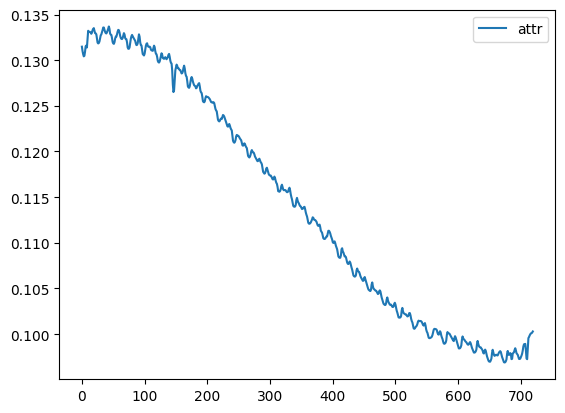

In [35]:
attr_df = pd.DataFrame({'attr':nt_ig_attr_score})
attr_df.plot()

### &rightarrow; 최근데이터가 매우강조 되는것을 확인할 수 있다.

#### scaling

* 표준화는 데이터가 정규분포를 따른다고 가정해야지 1sigma와 -1sigma에 68%정도의 데이터가 모여있음
* 데이터를 z-score로 변환(즉, 데이터를 표준화 또는 정규화)한다고 해서 데이터가 정규분포가 되는 것은 아니다. 단지 비교를 목적으로 데이터를 표준정규분포와 같은 척도로 만드는 것 뿐이다.
* 결과적으로 원래 정규분포의 형태였던 분포를 공통척도(평균은 0 표준편차는 1)로 바꾸는 것

https://hleecaster.com/ml-normalization-concept/

## 아무런 Scaling을 하지 않았을때

<AxesSubplot: >

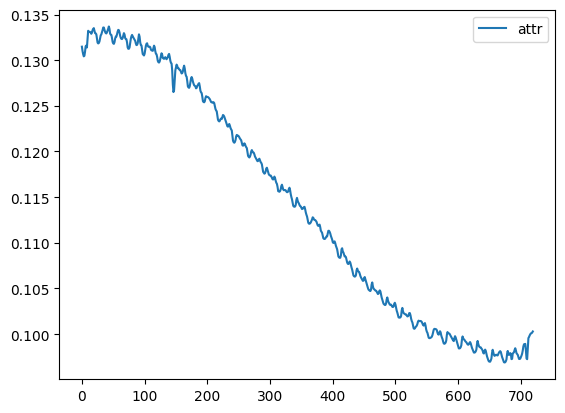

In [36]:
attr_df = attr_df.abs()
attr_df.plot()

## Outlier정의 계수(1.5)도 파라미터로 정할수 있도록

In [37]:
IQR = 1.5*(attr_df.quantile(0.75)-attr_df.quantile(0.25))
outlier_max = attr_df.quantile(0.75)+IQR
outlier_min = attr_df.quantile(0.25)-IQR
candidate_attr = attr_df[(attr_df>=outlier_min) & (attr_df<=outlier_max)]
candidate_attr = candidate_attr.dropna()
candidate_attr

,attr
0,0.131475
1,0.130998
2,0.130653
3,0.130418
4,0.130473
...,...
715,0.099978
716,0.100069
717,0.100092
718,0.100159


In [38]:
outlier_max

attr    0.166362
dtype: float64

In [39]:
outlier_min

attr    0.061742
dtype: float64

<AxesSubplot: >

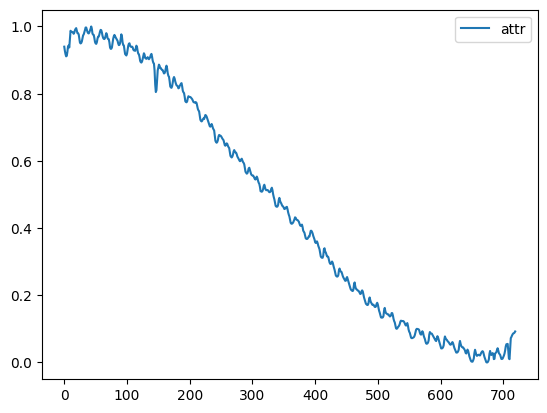

In [40]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
scaler.fit(candidate_attr.values)
m_attr_df = scaler.transform(attr_df.values)
m_attr_df = pd.DataFrame({"attr":m_attr_df.reshape(-1)})
# attr_df = attr_df.abs()
# attr_std = attr_df.std().item()
# attr_min = attr_df.min().item()
m_attr_df.plot()

In [41]:
m_attr_df.describe()

,attr
count,720.000000
mean,0.466915
std,0.347542
min,0.000000
25%,0.111179
50%,0.433232
75%,0.821797
max,1.000000


## 0과 1사이의 분포 확인하기

In [42]:
m_attr_df[(m_attr_df>=0) & (m_attr_df<=1)].dropna()

,attr
0,0.939881
1,0.926905
2,0.917545
3,0.911146
4,0.912642
...,...
715,0.084116
716,0.086596
717,0.087219
718,0.089026


* outlier를 제외하면 들어와있음을 확인할 수 있다.

<AxesSubplot: >

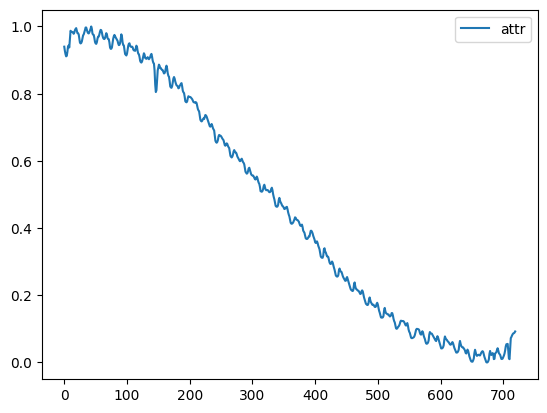

In [43]:
m_attr_df[(m_attr_df>=0) & (m_attr_df<=1)].dropna().plot()

### MinMaxScaler와 비교

<AxesSubplot: >

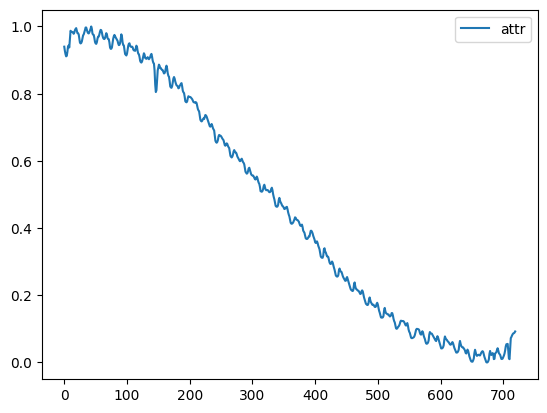

In [44]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
attr_df = scaler.fit_transform(attr_df.values)
attr_df = pd.DataFrame({"attr":attr_df.reshape(-1)})
# attr_df = attr_df.abs()
# attr_std = attr_df.std().item()
# attr_min = attr_df.min().item()
attr_df.plot()

#### train_index구하기

In [45]:
index_list = []

for hyper_para in np.arange(0.00,1.01,0.01):
    append_idx = list(m_attr_df[(m_attr_df['attr']>=hyper_para)].index)
    index_list.append(append_idx)
len(index_list) # train_index의 리스트

101

In [46]:
len_list=[]
for i in range(101):
    len_list.append(len(index_list[i]))


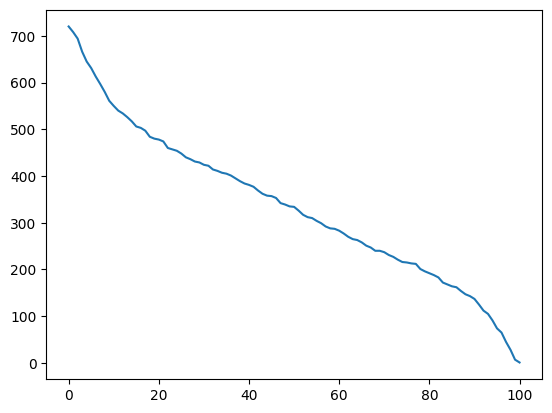

In [47]:
plt.plot(np.arange(101),len_list) # 포함되는 time_index의 갯수

In [48]:
### 원래 난수가 선언된 위치
m = len(validation)
n = len(training)
cnt = 0
mse_out_list = []
mae_out_list = []
smape_out_list = []
rmse_out_list = []
num_epochs = 100
for idx in index_list: #0.01~1.00 100개의 index에 대해서 수행
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
    train_idx = idx
    minimal_loss=np.inf
    model = Model(train_idx).to(device) # 모델 초기화
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
    result = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in training:
            # forward pass
            inputs = inputs
            
            outputs = model(inputs)
            outputs = outputs.view(-1,1)
            labels = labels.view(-1,1)            
            # defining loss
            loss = MSE(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch == 99:    
            print(f'{cnt}번째 모델 Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
        
        if (running_loss/n)*100<minimal_loss:
            best_model = copy.deepcopy(model)
            minimal_loss = (running_loss/n)*100
            print("changed")

    model = best_model
    cnt+=1
    # 모델 Fully-Training 완료
    
    pred = torch.FloatTensor().to(device)
    val_target = torch.FloatTensor().to(device)
    for val_x,val_y in validation:
        tmp_pred = model(val_x)
        pred = torch.concat([pred,tmp_pred], dim=0)
        val_target = torch.concat([val_target,val_y],dim = 0)
    pred = pred.view(-1,1)
    val_target = val_target.view(-1,1)
    result = MSE(pred,val_target).item()
    mse_out_list.append(result)
    mae_out_list.append(MAE()(pred,val_target).item())
    rmse_out_list.append(RMSE()(pred,val_target).item())
    smape_out_list.append(SMAPE()(pred,val_target).item()*100)

changed
changed
changed
0번째 모델 Training 완료 마지막 Epoch loss:44054.52342609783
changed
changed
changed
1번째 모델 Training 완료 마지막 Epoch loss:43967.83277909834
changed
changed
changed
2번째 모델 Training 완료 마지막 Epoch loss:43847.54833179516
changed
changed
changed
changed
3번째 모델 Training 완료 마지막 Epoch loss:43644.671630859375
changed
changed
changed
changed
changed
4번째 모델 Training 완료 마지막 Epoch loss:43510.67503206023
changed
changed
changed
changed
changed
changed
5번째 모델 Training 완료 마지막 Epoch loss:43443.95473605984
changed
changed
changed
changed
changed
changed
changed
6번째 모델 Training 완료 마지막 Epoch loss:43390.04570258843
changed
changed
changed
changed
changed
changed
changed
changed
changed
7번째 모델 Training 완료 마지막 Epoch loss:43394.77352938809
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
8번째 모델 Training 완료 마지막 Epoch loss:43396.50498274918
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
9번째

changed
changed
56번째 모델 Training 완료 마지막 Epoch loss:52553.35502205314
changed
changed
57번째 모델 Training 완료 마지막 Epoch loss:52368.751341432006
changed
changed
58번째 모델 Training 완료 마지막 Epoch loss:52243.64010318295
changed
changed
59번째 모델 Training 완료 마지막 Epoch loss:52164.37193482786
changed
changed
60번째 모델 Training 완료 마지막 Epoch loss:52042.75489220252
changed
changed
changed
61번째 모델 Training 완료 마지막 Epoch loss:51898.095636053404
changed
changed
changed
62번째 모델 Training 완료 마지막 Epoch loss:51700.172005118904
changed
changed
changed
63번째 모델 Training 완료 마지막 Epoch loss:51575.9025154533
changed
changed
changed
64번째 모델 Training 완료 마지막 Epoch loss:51511.57176258799
changed
changed
changed
65번째 모델 Training 완료 마지막 Epoch loss:51415.212878552105
changed
changed
changed
66번째 모델 Training 완료 마지막 Epoch loss:51243.984146956565
changed
changed
changed
67번째 모델 Training 완료 마지막 Epoch loss:51171.5311574412
changed
changed
changed
68번째 모델 Training 완료 마지막 Epoch loss:51101.18579235706
changed
changed
changed
69번째 모델 Trai

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
90번째 모델 Training 완료 마지막 Epoch loss:52638.41426975124
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
91번째 모델 Training 완료 마지막 Epoch loss:

/home/sjlee/sj_virtual/lib/python3.8/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/home/sjlee/sj_virtual/lib/python3.8/site-packages/torch/nn/modules/linear.py:114: UserWarning: An output with one or more elements was resized since it had shape [64, 360], which does not match the required output shape [360]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:17.)
  return F.linear(input, self.weight, self.bias)


RuntimeError: The size of tensor a (360) must match the size of tensor b (23040) at non-singleton dimension 0

In [49]:
val_y # 다음 예측 타겟값

tensor([[ 94.5946, 100.2845, 109.5306,  ..., 101.7070,  94.5946,  91.7496],
        [100.2845, 109.5306, 113.7980,  ...,  94.5946,  91.7496,  95.3058],
        [109.5306, 113.7980,  98.1508,  ...,  91.7496,  95.3058,  92.4609],
        ...,
        [ 82.5036,  75.3912,  69.7013,  ...,  96.0171,  88.1935,  88.1935],
        [ 75.3912,  69.7013,  66.8563,  ...,  88.1935,  88.1935,  84.6373],
        [ 69.7013,  66.8563,  64.7226,  ...,  88.1935,  84.6373,  79.6586]],
       device='cuda:0')

In [50]:
val_x # 예측 하는 값

tensor([[ 93.8834, 102.4182, 101.7070,  ..., 108.1081, 103.8407, 101.7070],
        [102.4182, 101.7070, 100.2845,  ..., 103.8407, 101.7070,  94.5946],
        [101.7070, 100.2845,  94.5946,  ..., 101.7070,  94.5946, 100.2845],
        ...,
        [ 83.2148,  76.1024,  71.1238,  ..., 113.7980, 101.7070,  91.0384],
        [ 76.1024,  71.1238,  68.2788,  ..., 101.7070,  91.0384,  82.5036],
        [ 71.1238,  68.2788,  66.8563,  ...,  91.0384,  82.5036,  75.3912]],
       device='cuda:0')

In [51]:
result/68

0.0

In [52]:
val_x.size()

torch.Size([33, 720])

           out
95  281.555206


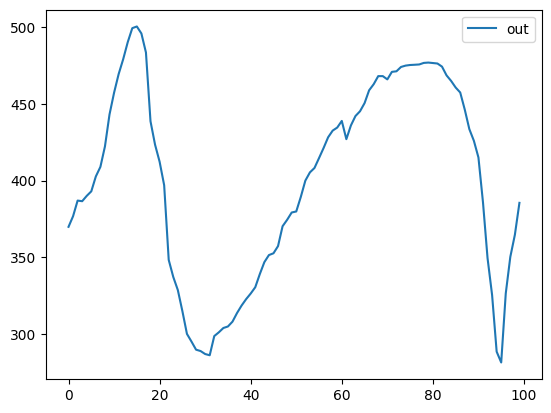

In [53]:
out_df = pd.DataFrame({"out":mse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [54]:
out_df 

,out
0,369.920410
1,376.853485
2,387.027557
3,386.620422
4,390.098755
...,...
95,281.555206
96,326.559540
97,350.371735
98,364.729065


        out
94  14.1035


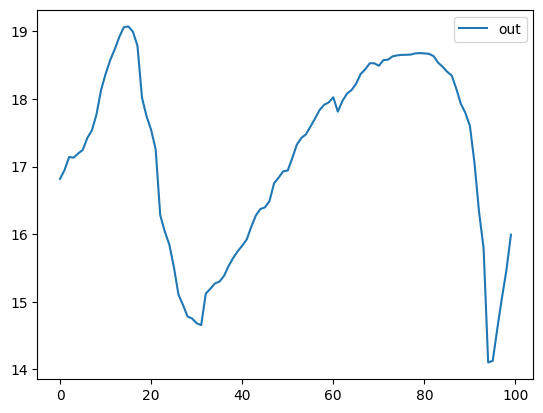

In [55]:
out_df = pd.DataFrame({"out":mae_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [56]:
out_df 

,out
0,16.816833
1,16.948851
2,17.140690
3,17.130608
4,17.193258
...,...
95,14.127579
96,14.597954
97,15.048285
98,15.462865


          out
94  15.604243


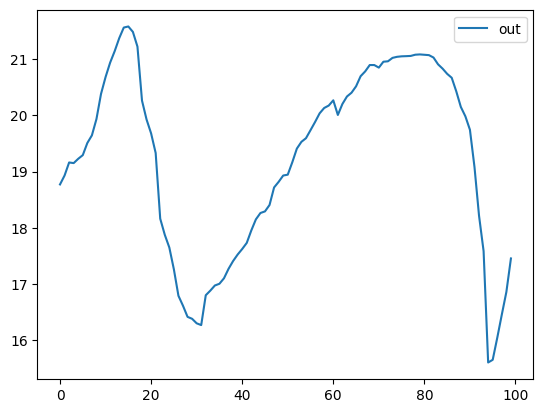

In [57]:
out_df = pd.DataFrame({"out":smape_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [58]:
out_df 

,out
0,18.771109
1,18.930016
2,19.161743
3,19.150577
4,19.227459
...,...
95,15.651564
96,16.043776
97,16.456476
98,16.858709


          out
95  16.779608


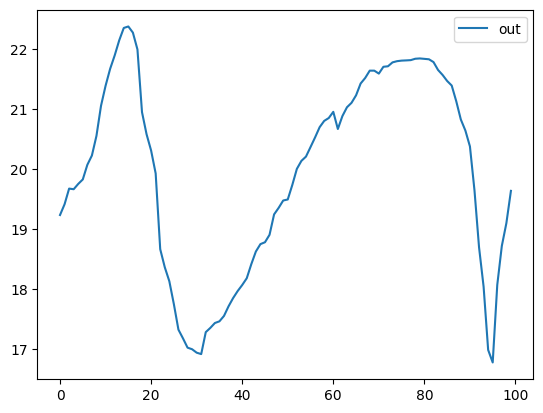

In [59]:
out_df = pd.DataFrame({"out":rmse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [1]:
out_df 

NameError: name 'out_df' is not defined

In [ ]:
attr_df.describe()